# BEER DATA ANALYSIS (STRATASCRATCH)

In [2]:
import pandas as pd
import numpy as np

In [3]:
PATH = "./datasets/BeerDataScienceProject.tar.bz2"
df = pd.read_csv(PATH, compression="bz2")
print (df)

        beer_ABV  beer_beerId  beer_brewerId               beer_name  \
0            5.0        47986          10325            Sausa Weizen   
1            6.2        48213          10325                Red Moon   
2            6.5        48215          10325  Black Horse Black Beer   
3            5.0        47969          10325              Sausa Pils   
4            7.7        64883           1075           Cauldron DIPA   
...          ...          ...            ...                     ...   
528865       NaN         4032           3340       Dinkel Acker Dark   
528866       NaN         4032           3340       Dinkel Acker Dark   
528867       NaN         4032           3340       Dinkel Acker Dark   
528868       NaN         4032           3340       Dinkel Acker Dark   
528869       NaN         4032           3340       Dinkel Acker Dark   

                            beer_style  review_appearance  review_palette  \
0                           Hefeweizen                2.5 

In [4]:
print (df["review_overall"].value_counts().sort_index(ascending=False))

review_overall
5.0     31028
4.5    110928
4.0    196544
3.5     98901
3.0     53707
2.5     18539
2.0     11931
1.5      3996
1.0      3293
0.0         3
Name: count, dtype: int64


In [5]:
df.shape

(528870, 13)

In [6]:
df.describe()

,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time
count,508590.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,5.288700e+05
mean,7.017442,22098.466016,2598.423429,3.864522,3.758926,3.833197,3.765993,3.817350,1.224885e+09
std,2.204460,22158.284352,5281.805350,0.604010,0.685335,0.709962,0.669018,0.718903,7.605600e+07
min,0.010000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08
25%,5.300000,1745.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.174613e+09
50%,6.500000,14368.000000,394.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.240366e+09
75%,8.500000,40528.000000,1475.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.288560e+09
max,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09


As there are 4 categories in beer review including: *review_appearance*, *review_palette, review_taste, review_aroma* and *review_overall*

There are some erroneous rows containing 0 in **review_appearance** and **review_overall**. So the best way to trick these false data is to ignoree them

In [7]:
df = df[df["review_appearance"] > 0]
df = df[df["review_overall"] > 0]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528867 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508587 non-null  float64
 1   beer_beerId         528867 non-null  int64  
 2   beer_brewerId       528867 non-null  int64  
 3   beer_name           528867 non-null  object 
 4   beer_style          528867 non-null  object 
 5   review_appearance   528867 non-null  float64
 6   review_palette      528867 non-null  float64
 7   review_overall      528867 non-null  float64
 8   review_taste        528867 non-null  float64
 9   review_profileName  528752 non-null  object 
 10  review_aroma        528867 non-null  float64
 11  review_text         528748 non-null  object 
 12  review_time         528867 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 56.5+ MB


To prevent some cases that 1 user may leave multiple reviews on the same products, we will need to drop those duplicates to ensure the quality of the data.

We would lile 1 review per user per beer. Hence, we will keep the highest review_overall if there are duplicates.

In [9]:
df = df.sort_values(by="review_overall", ascending=False).drop_duplicates(subset=["beer_beerId", "review_profileName"],
                                                                           keep="first")

In [10]:
df.dropna(inplace=True)
df.shape

(503696, 13)

## Q1: Rank the top 3 breweries which produce the strongest beers.

To determine whether the beers are strong or not, the level of "alcohol by volume" should be takeen into account. Hence, there are 2 most pivotal fields to answer thiis question.

- beer_ABV
- beer_brewerId

In [11]:
strong_beer_avg_sort = df.groupby("beer_brewerId")["beer_ABV"].mean().sort_values(ascending=False)
strong_beer_max_sort = df.groupby("beer_brewerId")["beer_ABV"].max().sort_values(ascending=False)
strong_beer_avg_sort.iloc[:5]

beer_brewerId
6513     19.228824
736      13.750000
24215    12.466667
36       12.445860
8540     11.750000
Name: beer_ABV, dtype: float64

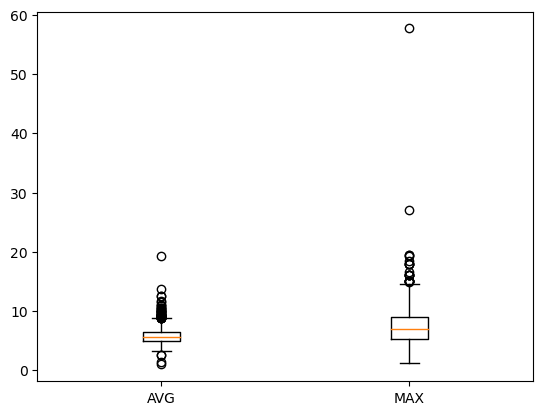

In [12]:
import matplotlib.pyplot as plt

plt.boxplot([strong_beer_avg_sort, strong_beer_max_sort], labels=["AVG", "MAX"])
plt.show()

## Q2: Which year did beers enjoy the highest ratings?

- The rating is recorded in the field of "review_overall"
- The year of that particular review can be extracted from: "review_time"

There are 2 factors to consider when judging whether a beer have the highest ratings or not
1. Its average overall rating
2. The number of review it gets

Some beers with just a few reviews will eventually get higher average score but that does not mean it is actually popular or have the highest rating.

In [13]:
df["review_year"] = pd.to_datetime(df["review_time"], unit="s").dt.year
review_avg_sort_year = df.groupby(
    "review_year")["review_overall"].mean().to_frame().reset_index().sort_values(by="review_overall",
                                                                                 ascending=False)
review_avg_sort_year.head(10)

,review_year,review_overall
2,2000,4.233333
0,1998,4.045455
1,1999,4.000000
3,2001,3.965485
12,2010,3.869701
11,2009,3.868522
7,2005,3.845709
10,2008,3.840636
14,2012,3.839000
13,2011,3.833462


In [14]:
review_num_sort_year = df.groupby("review_year").size().to_frame("review_count").reset_index()
q2 = review_num_sort_year.merge(review_avg_sort_year, on="review_year", how="inner")

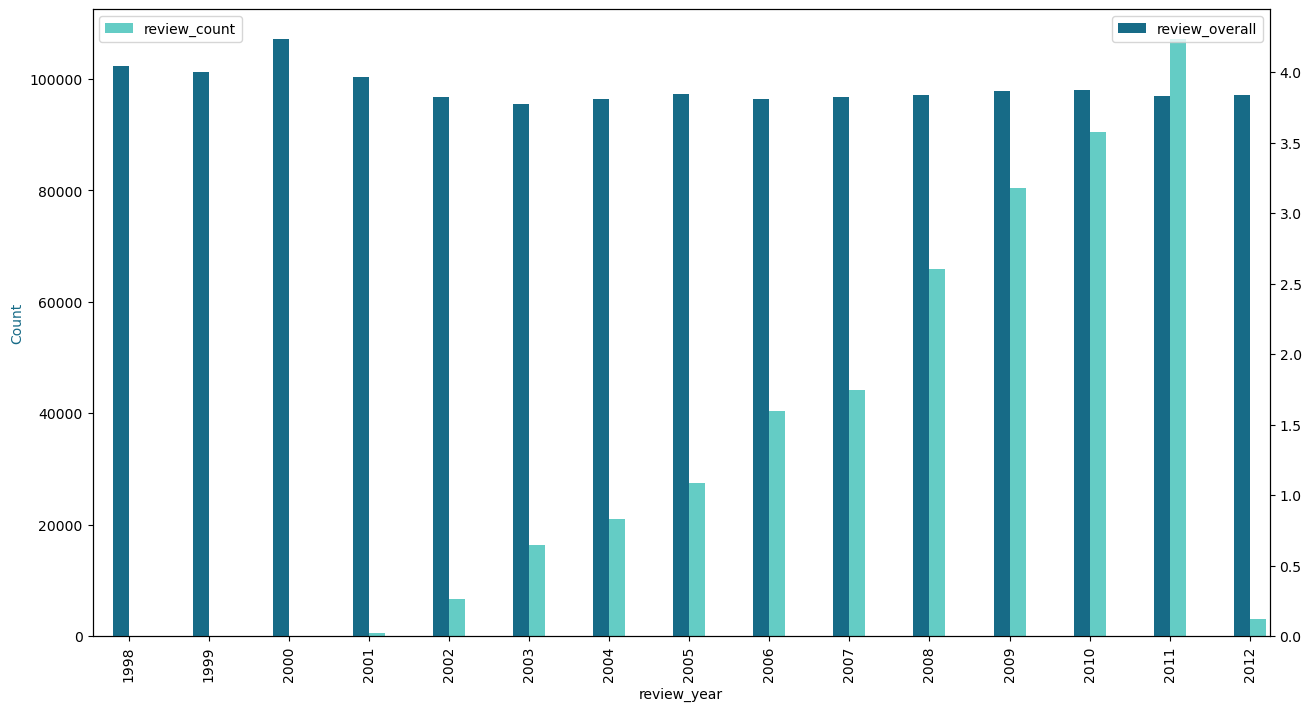

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(layout="constrained", figsize =(13,7))
ax2 = ax.twinx()
q2.plot(x="review_year", y="review_count", color='#64CCC5', kind="bar", ax=ax, width = 0.2, position=0)
q2.plot(x="review_year", y="review_overall", color='#176B87', kind="bar", ax=ax2, width = 0.2, position=1)
ax.set_ylabel("Count", loc='center', color="#176B87")

plt.show()


As it can be seen from the graph, the average overall scores barely change, it all range from around 3.8 to 4.5, yet the count of reviews in these year experience wild fluctuations. The highest count of reviews was seen in 2011 with more than a hundred thousand units, followed distantly by the year 2010 with roughly 90.000 units.

Therefore, it can be argued that 2010 and 2011 are two years with highest rating reviews. Personally, if there must be only 1 answer, I am more inclined towards the year 2011 due to each enormous amount of reviews and a generally high average score (~3.8)

## Q3: Based on the users' ratings, which factors are important among taste, aroma, appearance, and palette?


Still could not figure out how to do it.

! Learning more about correlation matrix

Higher cor = higher importance


In [16]:
q3 = df.groupby(by="beer_beerId")[[
    "review_taste",
    "review_aroma",
    "review_palette",
    "review_appearance",
    "review_overall"
]].mean()

q3

,review_taste,review_aroma,review_palette,review_appearance,review_overall
beer_beerId,,,,,
5,3.323810,3.342857,3.208333,3.488095,3.554762
6,3.514925,3.645235,3.514351,3.839265,3.709529
7,3.110687,3.103817,3.178626,3.251145,3.271756
8,3.301471,3.235294,3.080882,3.294118,3.647059
9,3.103448,3.043103,2.853448,3.051724,3.400862
...,...,...,...,...,...
77302,3.500000,3.500000,3.000000,3.000000,3.500000
77303,5.000000,4.500000,4.500000,4.500000,5.000000
77305,3.500000,4.000000,4.000000,4.000000,4.000000


In [17]:
corr_matrix = q3.corr()

In [31]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid --> remove outer border
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


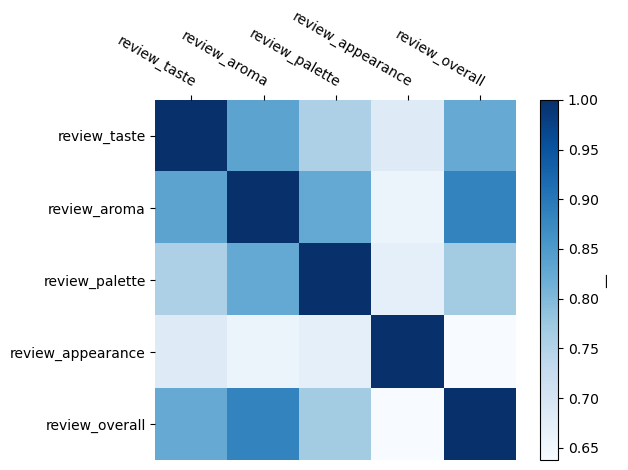

In [32]:
fig, ax = plt.subplots()

im, cbar = heatmap(corr_matrix, corr_matrix.index, corr_matrix.columns, ax=ax,
                   cmap="Blues", cbarlabel="__")

fig.tight_layout()
plt.show()

Practically, the one which has the largest coefficient witih review overall (according to the graph) is review_aroma with approximately 0,87. Hence, we can conclude that user mostly depend on aroma to judge the quality of the beer.


## Q4: If you were to recommend 3 beers to your friends based on this data, which ones would you recommend?

To recommend 3 beers, it is important to know our friends' preference.

Let say that, my friend is Tom. He is 19 years old. He does't have quite a good drinking capacity.
> "beer_ABV" is then an important factor (should be limit to 5 unit - below average)

He doesn't care much about the beer's style or appearance but want his beer to have an excellent taste and great aroma.
> pay attention to "review_aroma" and "review_taste"

Another crucial note is that, more reviews a beer gets, more accurate its rating is. So we should exclude all the beers which have fewer than 50 reviews. (50 is just an intuitive number)


In [76]:
quality = df.groupby("beer_beerId")[[
    "beer_ABV",
    "review_taste",
    "review_aroma",
    "review_palette",
    "review_appearance",
    "review_overall"
]].mean()
#recommendation = quality.loc[(quality["beer_ABV"]<=5.0) & (quality["review_aroma"]==5.0) & (quality["review_taste"]==5.0)]

review_num = df.groupby("beer_beerId").size().to_frame("review_count").reset_index()
recommendation = quality.merge(review_num, on='beer_beerId', how='inner')
recommendation = recommendation.loc[(recommendation["beer_ABV"]<=5.0) & 
                   (recommendation["review_aroma"]>4.0) &
                   (recommendation["review_taste"]>4.0) &
                   (recommendation["review_count"]>=100)]
recommendation = recommendation[["beer_beerId", "beer_ABV", "review_taste", "review_aroma", "review_count"]]

In [81]:
recommendation["2f_review"] = recommendation[["review_aroma", "review_taste"]].mean(axis=1)
recommendation.drop(["review_taste", "review_aroma"], axis=1, inplace=True)
recommendation

,beer_beerId,beer_ABV,review_count,2f_review
105,571,5.0,2024,4.233819
106,572,5.0,1149,4.117929
295,1577,4.0,824,4.330400
297,1585,4.0,708,4.305085
310,1632,5.0,525,4.166190
337,1703,5.0,412,4.317961
490,2557,5.0,556,4.134442
491,2558,5.0,216,4.188657
524,2704,5.0,531,4.081921
689,3659,5.0,245,4.375510


In [87]:
recommendation.sort_values(["2f_review"], ascending=False)[:3]

,beer_beerId,beer_ABV,review_count,2f_review
6348,36316,5.0,155,4.559677
980,5281,5.0,270,4.378704
689,3659,5.0,245,4.375510


## Q5: Which beer style seems to be the favourite based on the reviews written by users? How does written reviews compare to overall review score for the beer style?

This question involves machine learning, particularly Sentiment Analysis. Practically, the simplest way to solve this is to use  VADER (Valence Aware Dictionary and sEntiment Reasoner) tool so as to explore the "review_text" columns.

The tool will break the sentence down into 3 categories: positive, neutral and negative.

In [88]:
from nltk import download
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [89]:
download("vader_lexicon", quiet=True)

True

In [90]:
analyser = SentimentIntensityAnalyzer()
df["review_sentiment"] = df["review_text"].apply(lambda x: analyser.polarity_scores(text=x)["compound"])
df["review_sentiment"].head(10)

73150     0.9687
456473    0.9736
216758    0.9496
276655    0.9908
276664    0.9322
330060    0.9081
276688    0.3919
276692    0.9134
456368    0.9906
276697    0.9901
Name: review_sentiment, dtype: float64

In [91]:
df.groupby("beer_style")["review_sentiment"].agg(func=["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
beer_style,,
Quadrupel (Quad),0.857262,4808
Dortmunder / Export Lager,0.855526,1709
Flanders Red Ale,0.852636,2751
Roggenbier,0.850934,137
Braggot,0.850208,197
...,...,...
Happoshu,0.533456,55
American Malt Liquor,0.524823,1332
Japanese Rice Lager,0.516839,488


According to sentiments extracted from review_text, Quadrupel (Quad) is the most favourite beer to users, with 0,857 point as shown above.

In [94]:
q5 = df[df["beer_style"]=="Quadrupel (Quad)"]
q5[["review_overall", "review_sentiment"]].corr()


,review_overall,review_sentiment
review_overall,1.000000,0.259541
review_sentiment,0.259541,1.000000


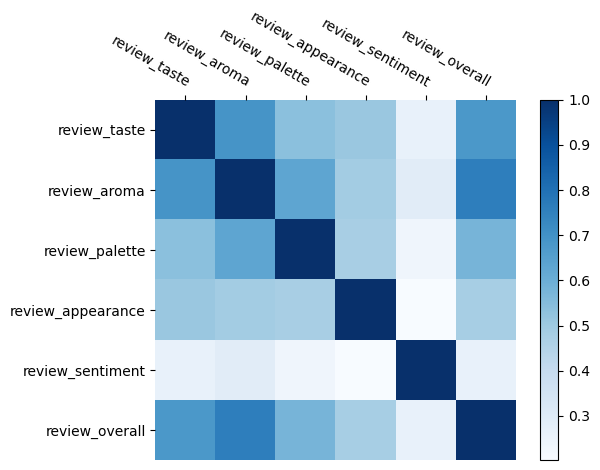

In [97]:
review_category = [
    "review_taste",
    "review_aroma",
    "review_palette",
    "review_appearance",
    "review_sentiment",
    "review_overall"
    ]

fig, ax = plt.subplots()

im, cbar = heatmap(q5[[
    "review_taste",
    "review_aroma",
    "review_palette",
    "review_appearance",
    "review_sentiment",
    "review_overall"]].corr(), review_category, review_category, ax=ax,
                   cmap="Blues", cbarlabel="")

fig.tight_layout()
plt.show()

All review attributes score similarly, at around 0.2 correlation. It means that usually, user tend to rate higher point than how their text expresses. This can happen due to some subsequent causes: 

This is expected because a single number (the overall review) better expresses the users' opinion of the beer than the written text; that is from the viewpoint of a computer, because the NLP model is not performing at human-level. Moreover, a user could have given a high review of the beer, but leave a rather neutral comment / text. This contributes to the low correlation coefficient. The overall gist is that the coefficient is positive, indicating that increase in the compound score is correlated with an increase in the overall review score.